In [1]:
import sys
import os
import numpy as np
import pandas as pd


In [3]:
#Read targets

targets_strand_df = pd.read_csv('/home/drk/seqnn/data/models/v2/f0c0/testg-0/acc.txt', index_col=0, sep='\t')[['identifier', 'description']]


In [4]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

#Get dataframe columns (identifiers)
cols = targets_strand_df['identifier'].values.tolist()


In [5]:
#Filter on GTEx targets only (last 89 rows)

targets_strand_df = targets_strand_df.iloc[-89:].copy()


In [6]:
#Compile dictionary of tissue targets (with replicates)
tissues = sorted(targets_strand_df['description'].unique().tolist())
tissues = [tissue[4:] for tissue in tissues]

tissue_dict = {}

#Loop over target rows (output tracks)
for _, row in targets_strand_df.iterrows() :
    target_i = row['row_index']
    
    tissue = row['description'][4:]
    
    #Add output track index if it matches the current tissue of interest
    if tissue in tissues :
        if tissue not in tissue_dict :
            tissue_dict[tissue] = []

        tissue_dict[tissue].append(target_i)


In [7]:
#Make 'other' tissues (all but the current tissue of interest)

#Loop over tissues
for tissue in tissues :
    tissue_targets = set(tissue_dict[tissue])
    
    other_targets = []
    
    #Loop over tisses (again)
    for other_tissue in tissues :
        other_tissue_targets = tissue_dict[other_tissue]
        
        #Add tissue other than the tissue of interest
        if other_tissue != tissue :
            #Loop over tissue output track indices
            for other_target_i in other_tissue_targets :
                if other_target_i not in tissue_targets :
                    other_targets.append(other_target_i)
    
    tissue_dict[tissue + '_other'] = other_targets

tissues = tissues + [tissue + '_other' for tissue in tissues]


In [8]:
#Estimate pseudo counts from first fold (for predictions and measurements)

#Pseudo count quantile
pseudo_qtl = 0.05

#Fold to compute pseudo count from
fold_ix = 0

df_pred = pd.read_csv("/home/drk/seqnn/data/models/v2/f" + str(fold_ix) + "c0/testg-0/gene_preds.tsv", sep='\t')
df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

df_true = pd.read_csv("/home/drk/seqnn/data/models/v2/f" + str(fold_ix) + "c0/testg-0/gene_targets.tsv", sep='\t')
df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

#Compute pseudo count by target
pseudo_cov_pred = np.zeros(targets_strand_df.shape[0], dtype='float32')
pseudo_cov_true = np.zeros(targets_strand_df.shape[0], dtype='float32')

target_to_local_index_dict = {}

#Loop over targets
for ii, [_, row] in enumerate(targets_strand_df.iterrows()) :
    target_i = row['row_index']
    
    #Compute pseudo count from chosen target quantile (non-zero measured pA signals only)
    nonzero_index = np.nonzero(df_true[cols[target_i]].values != 0.)[0]
    
    pseudo_cov_pred[ii] = np.quantile(2**df_pred.iloc[nonzero_index][cols[target_i]].values - 1., q=pseudo_qtl)
    pseudo_cov_true[ii] = np.quantile(2**df_true.iloc[nonzero_index][cols[target_i]].values - 1., q=pseudo_qtl)
    
    target_to_local_index_dict[target_i] = ii


In [9]:
#Load gene dataframe

gene_df = pd.read_csv('/home/drk/seqnn/data/models/v2/f0c0/testg-0/genes.bed', sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'feat1', 'strand'])[['chrom', 'gene_id', 'strand']].drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)


In [10]:
#Load and augment measured / predicted coverages to gene dataframe

fold_index = [0, 1, 2, 3]

cov_pred_dict = {}
cov_true_dict = {}
cov_pred_dict_test = {}
cov_true_dict_test = {}
fold_dict = {}

#Loop over train / valid / test splits
for split_label in ['test'] :
    
    print("--- split_label = " + str(split_label) + " ---")

    #Loop over folds
    for fold_ix in fold_index :

        print("Processing fold = " + str(fold_ix))

        #Load predictions
        df_pred = pd.read_csv("/home/drk/seqnn/data/models/v2/f" + str(fold_ix) + "c0/testg-0/gene_preds.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Load targets
        df_true = pd.read_csv("/home/drk/seqnn/data/models/v2/f" + str(fold_ix) + "c0/testg-0/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Aggregate average coverages for tissue replicates
        drop_columns = []

        #Loop over tissues
        for tissue in tissues :
            df_pred[tissue + '_pred'] = 0.
            df_true[tissue + '_true'] = 0.

            #Loop over tissue output track indices
            for tissue_i in tissue_dict[tissue] :
                df_pred[tissue + '_pred'] += (2**df_pred[cols[tissue_i]] - 1. + pseudo_cov_pred[target_to_local_index_dict[tissue_i]])
                df_true[tissue + '_true'] += (2**df_true[cols[tissue_i]] - 1. + pseudo_cov_true[target_to_local_index_dict[tissue_i]])

                drop_columns.append(cols[tissue_i])

            df_pred[tissue + '_pred'] /= len(tissue_dict[tissue])
            df_true[tissue + '_true'] /= len(tissue_dict[tissue])

        df_pred = df_pred.drop(columns=drop_columns).copy().reset_index(drop=True)
        df_true = df_true.drop(columns=drop_columns).copy().reset_index(drop=True)

        #Accumulate in pred dictionary (ensemble)
        for _, row in df_pred.iterrows() :
            if row['gene_id'] not in cov_pred_dict :
                cov_pred_dict[row['gene_id']] = {}

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_pred_dict[row['gene_id']] :
                    cov_pred_dict[row['gene_id']][tissue] = 0.
                
                cov_pred_dict[row['gene_id']][tissue] += row[tissue + '_pred'] / float(len(fold_index))

        #Accumulate in true dictionary (ensemble)
        for _, row in df_true.iterrows() :
            if row['gene_id'] not in cov_true_dict :
                cov_true_dict[row['gene_id']] = {}

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_true_dict[row['gene_id']] :
                    cov_true_dict[row['gene_id']][tissue] = 0.
                
                cov_true_dict[row['gene_id']][tissue] += row[tissue + '_true'] / float(len(fold_index))
        
        #Store test fold predicitons separately
        if split_label == 'test' :
        
            #Add onto pred dictionary (test fold only)
            for _, row in df_pred.iterrows() :
                if row['gene_id'] not in cov_pred_dict_test :
                    cov_pred_dict_test[row['gene_id']] = {}
                    fold_dict[row['gene_id']] = fold_ix

                    #Loop over tissues
                    for tissue in tissues :
                        cov_pred_dict_test[row['gene_id']][tissue] = row[tissue + '_pred']
                else :
                    print("[Warning] Duplicate test fold entries for gene_id = '" + str(row['gene_id']) + "' (pred)")
            
            #Add onto true dictionary (test fold only)
            for _, row in df_true.iterrows() :
                if row['gene_id'] not in cov_true_dict_test :
                    cov_true_dict_test[row['gene_id']] = {}

                    #Loop over tissues
                    for tissue in tissues :
                        cov_true_dict_test[row['gene_id']][tissue] = row[tissue + '_true']
                else :
                    print("[Warning] Duplicate test fold entries for gene_id = '" + str(row['gene_id']) + "' (true)")

print("len(cov_pred_dict) = " + str(len(cov_pred_dict)))
print("len(cov_true_dict) = " + str(len(cov_true_dict)))
print("len(cov_pred_dict_test) = " + str(len(cov_pred_dict_test)))
print("len(cov_true_dict_test) = " + str(len(cov_true_dict_test)))
print("len(fold_dict) = " + str(len(fold_dict)))


--- split_label = test ---
Processing fold = 0
Processing fold = 1
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000106603.20' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000185760.18' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000213020.10' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000106603.20' (true)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000185760.18' (true)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000213020.10' (true)
Processing fold = 2
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000077943.8' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000100154.15' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000122390.19' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000151914.22' (pred)
[Warning] Duplicate test fold entries for gene_id = 'ENSG00000172197.11' (pred)
[Warning] Duplicate test fold entr

In [11]:
#Append measurements and predictions from dictionaries to main gene dataframe

fold_strs = []

#Loop over genes in dataframe
for _, row in gene_df.iterrows() :
    if row['gene_id'] in fold_dict :
        fold_strs.append('f' + str(fold_dict[row['gene_id']]))
    else :
        fold_strs.append(None)

gene_df['test_fold'] = fold_strs

#Loop over tissues
for tissue in tissues :
    pred_covs = []
    true_covs = []
    pred_covs_test = []
    true_covs_test = []
    
    #Loop over genes in dataframe
    for _, row in gene_df.iterrows() :
        
        #Add trained-on gene predictions and measurements
        if row['gene_id'] in cov_pred_dict :
            pred_covs.append(cov_pred_dict[row['gene_id']][tissue])
            true_covs.append(cov_true_dict[row['gene_id']][tissue])
        else :
            pred_covs.append(None)
            true_covs.append(None)
        
        #Add held-out gene predictions and measurements
        if row['gene_id'] in cov_pred_dict_test :
            pred_covs_test.append(cov_pred_dict_test[row['gene_id']][tissue])
            true_covs_test.append(cov_true_dict_test[row['gene_id']][tissue])
        else :
            pred_covs_test.append(None)
            true_covs_test.append(None)
    
    gene_df[tissue + '_pred'] = pred_covs
    gene_df[tissue + '_true'] = true_covs
    
    gene_df[tissue + '_test_pred'] = pred_covs_test
    gene_df[tissue + '_test_true'] = true_covs_test

print("len(gene_df) = " + str(len(gene_df)))


len(gene_df) = 19670


In [12]:
#Save gene dataframe with predictions and measurements

gene_df.to_csv('genes_gtex_test.csv.gz', index=False, sep='\t', compression='gzip')


In [13]:
#(Re-)Load gene dataframe

gene_df = pd.read_csv('genes_gtex_test.csv.gz', sep='\t', compression='gzip')


Evaluating for fold = 0
spearman r = 0.979
p = 0.0
n = 2487
(pearson r = 0.967)


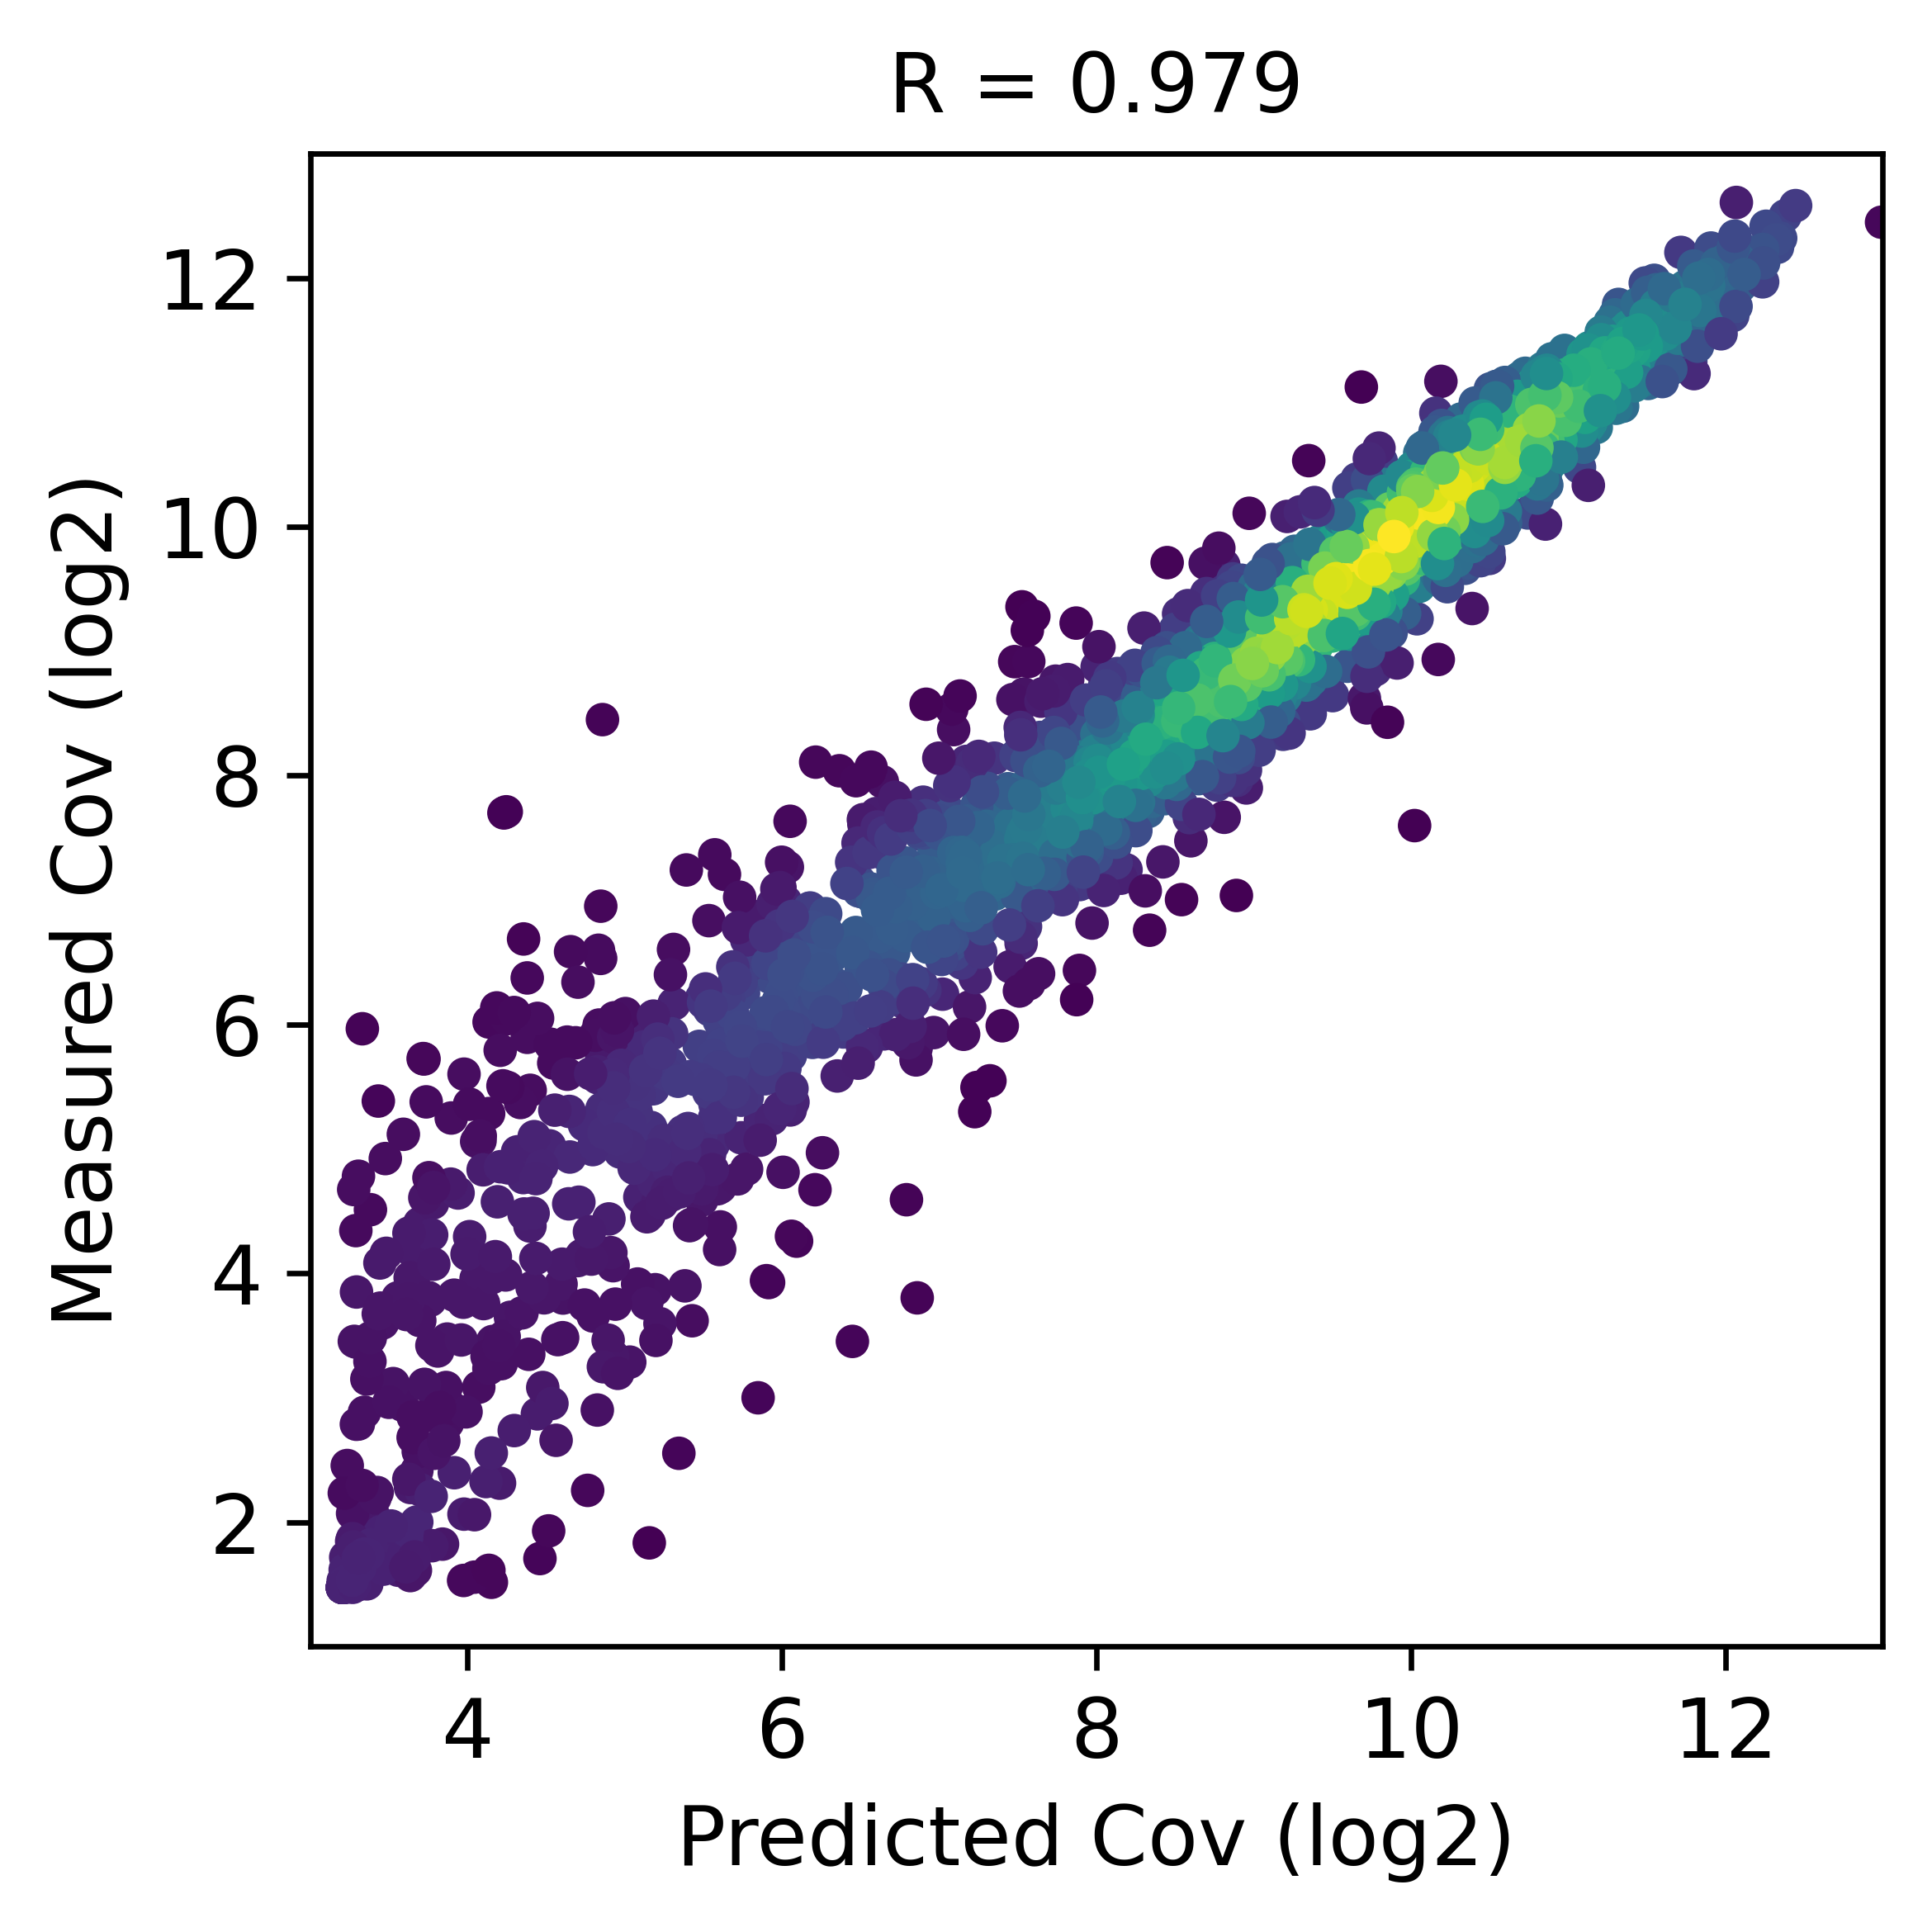

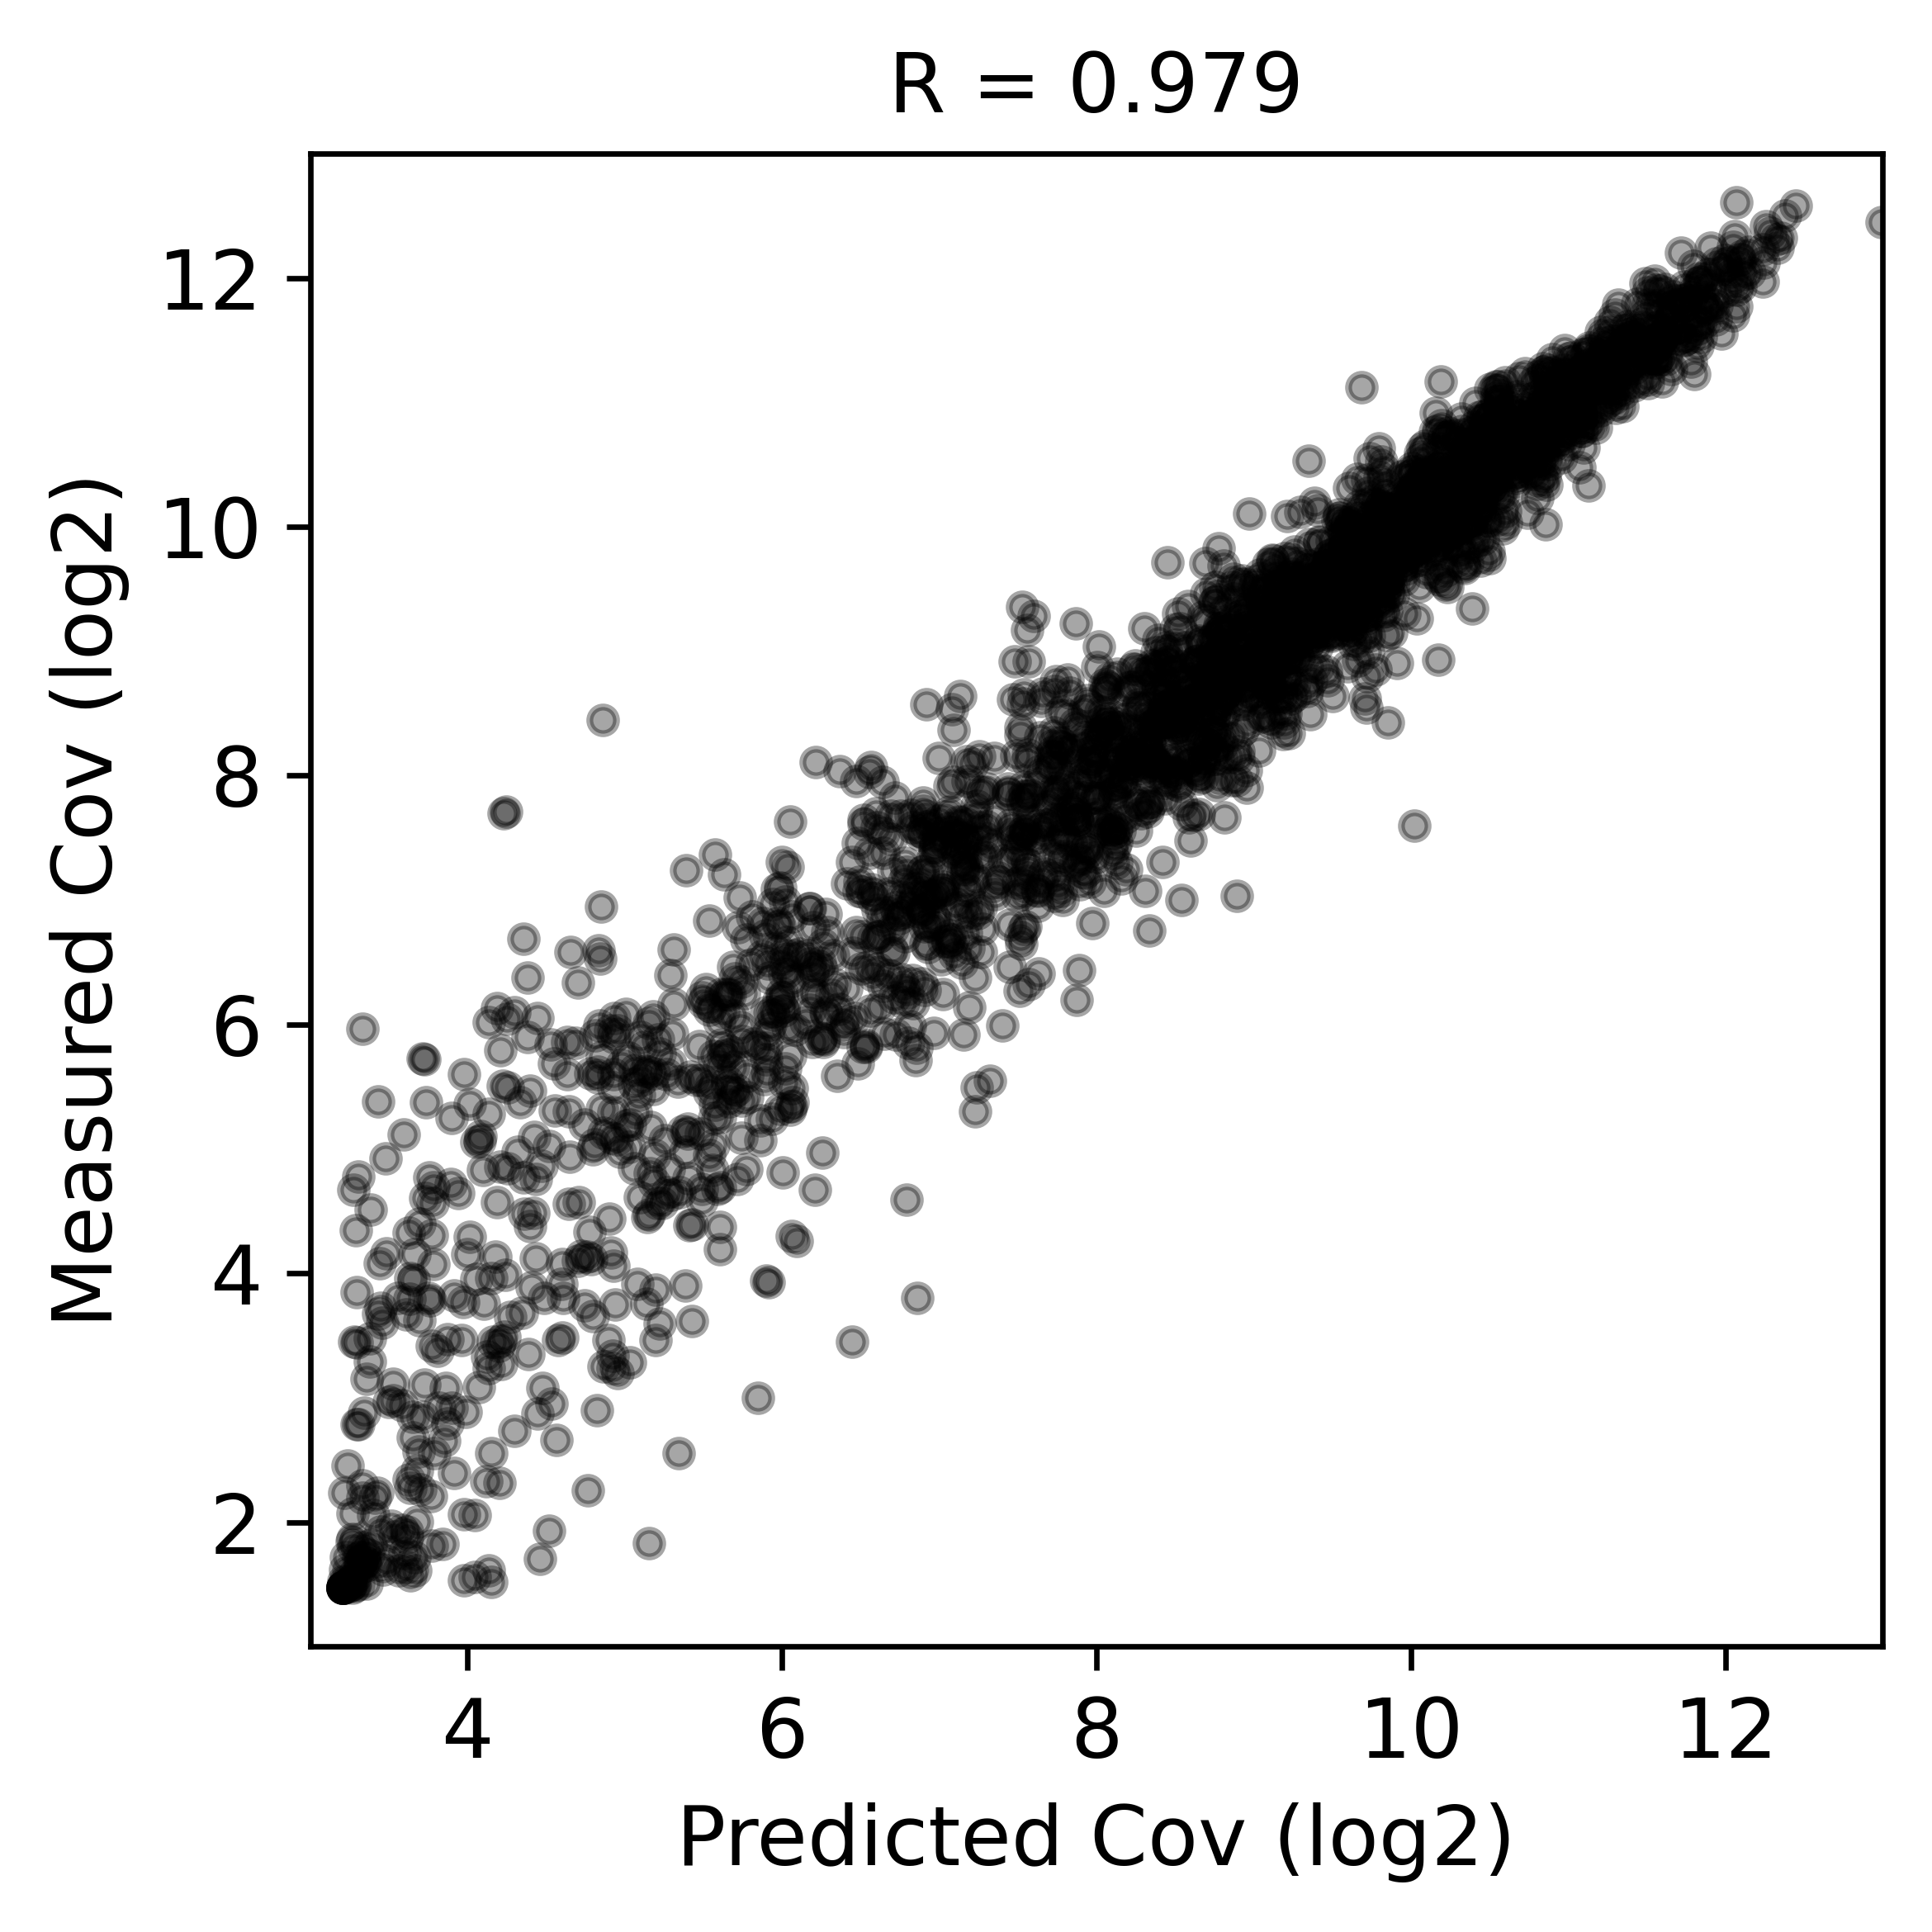

Evaluating for fold = 1
spearman r = 0.984
p = 0.0
n = 3030
(pearson r = 0.975)


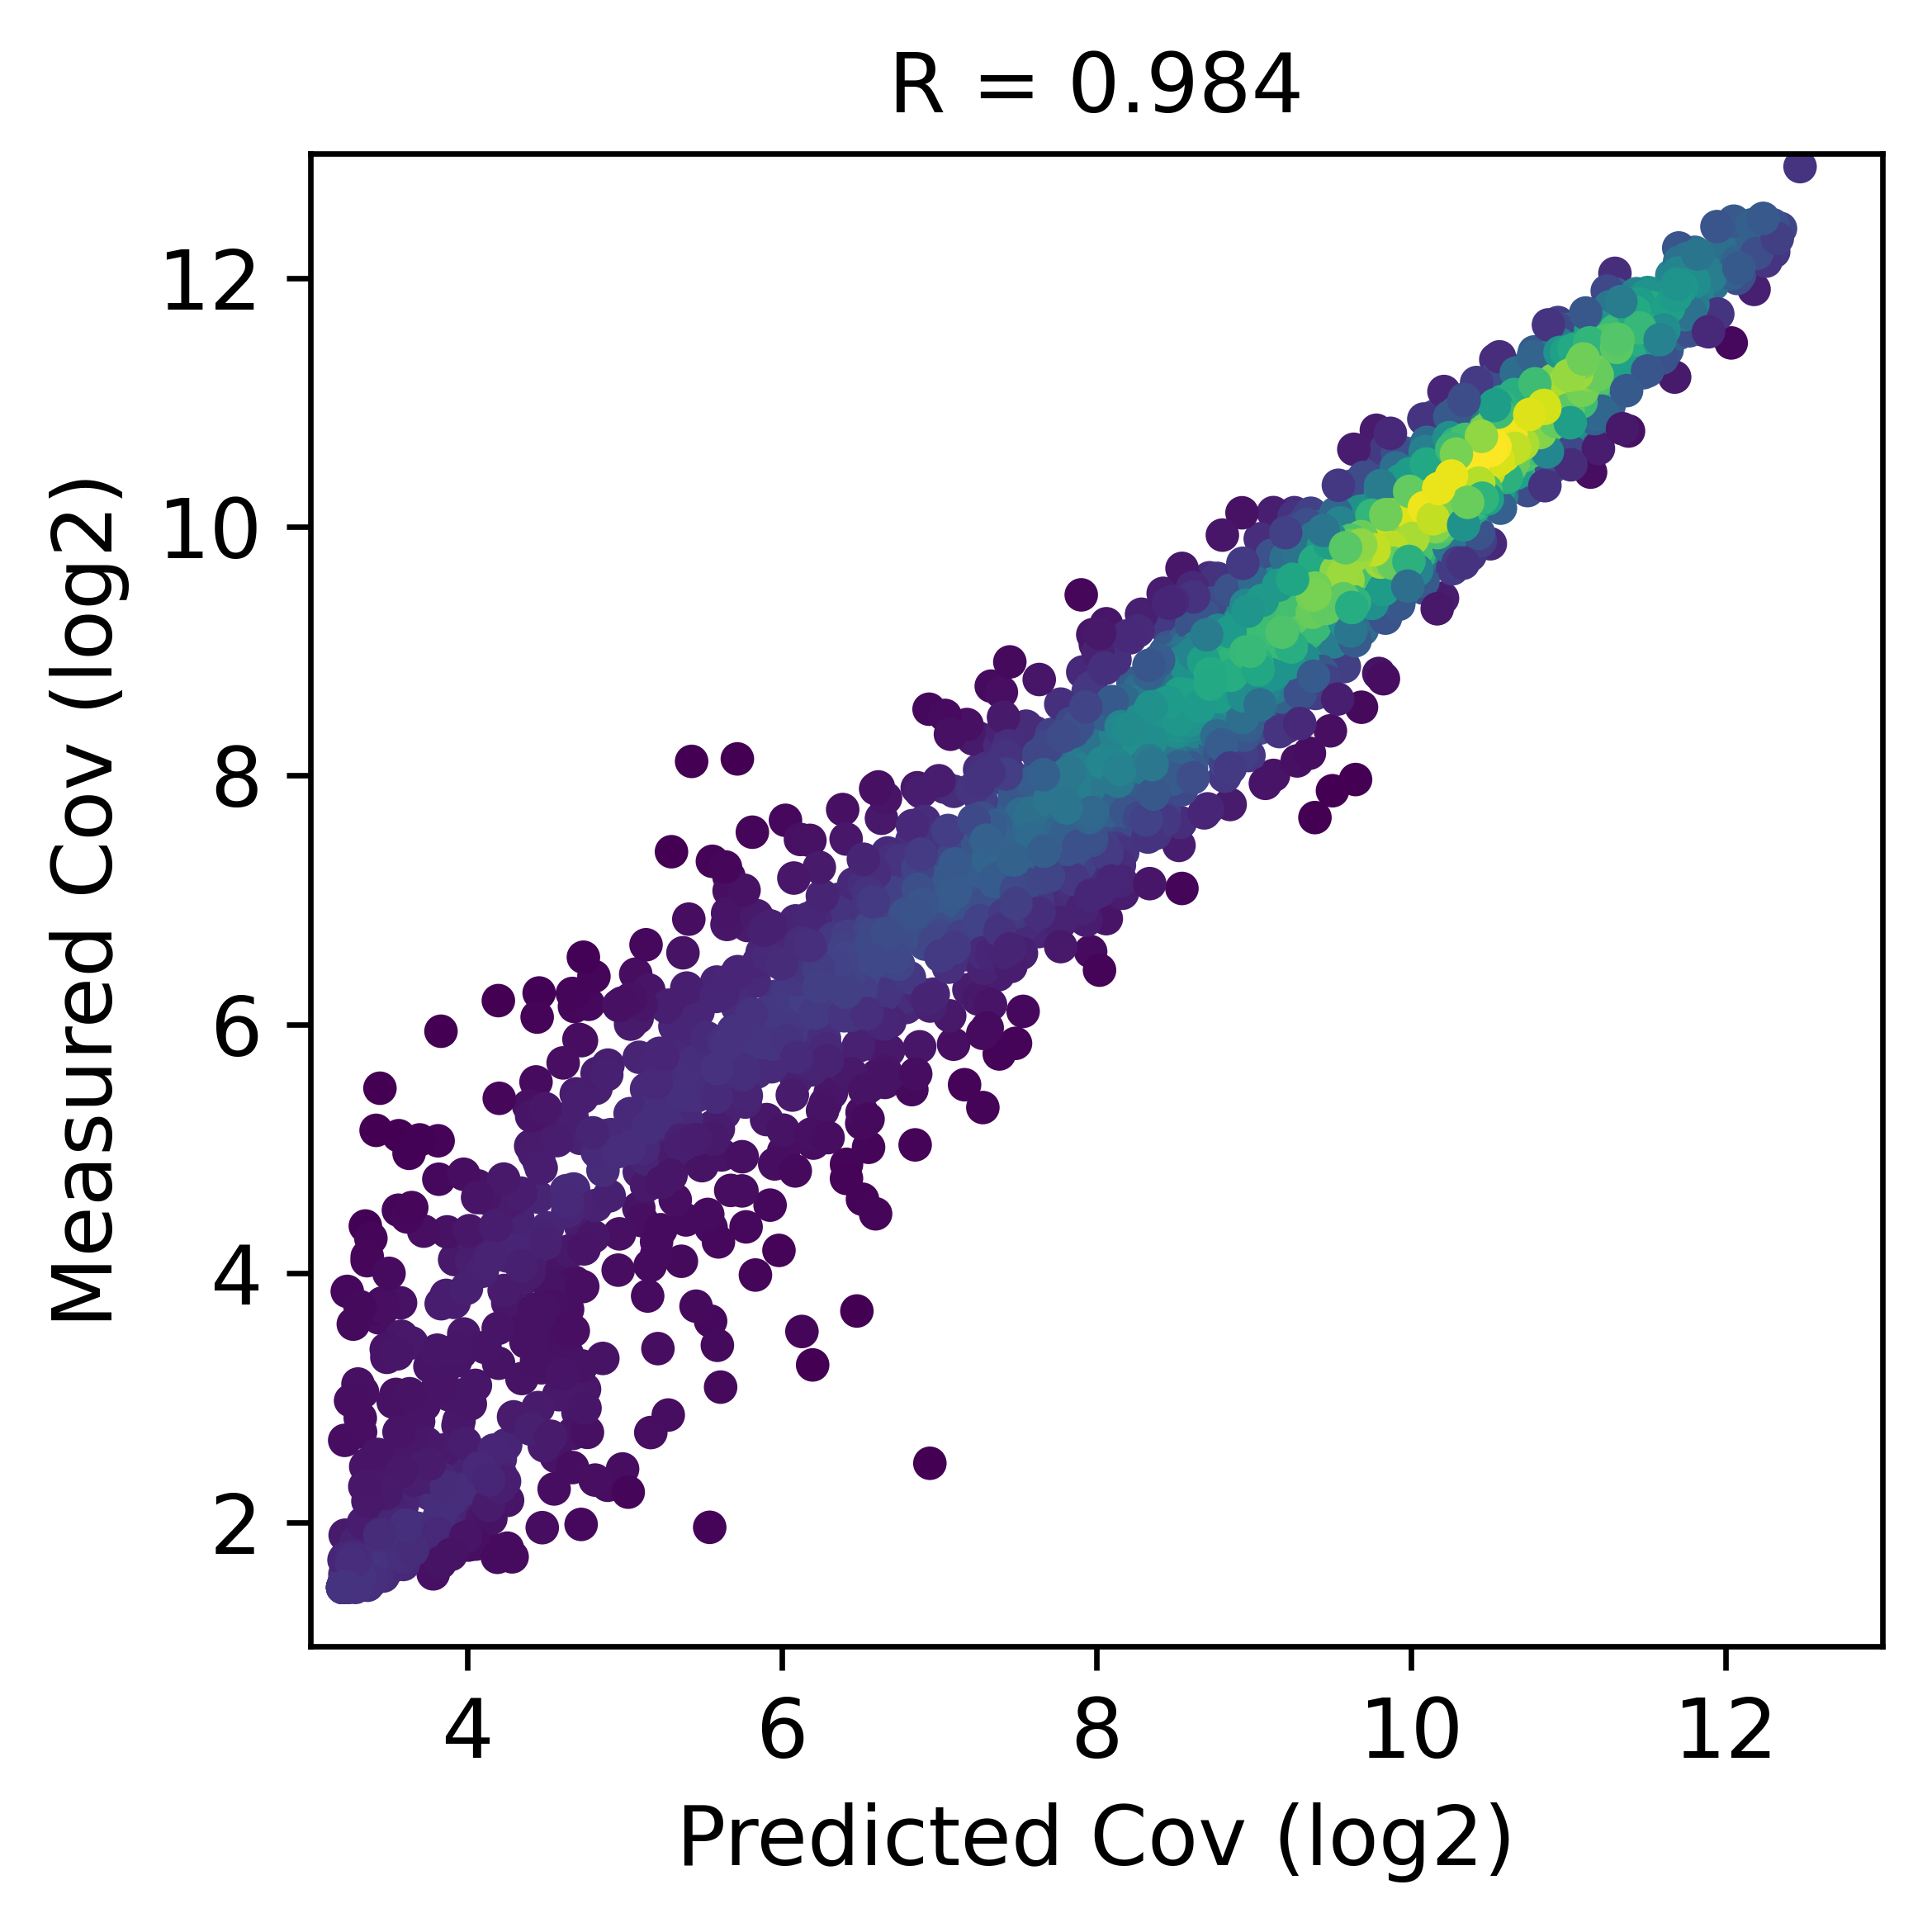

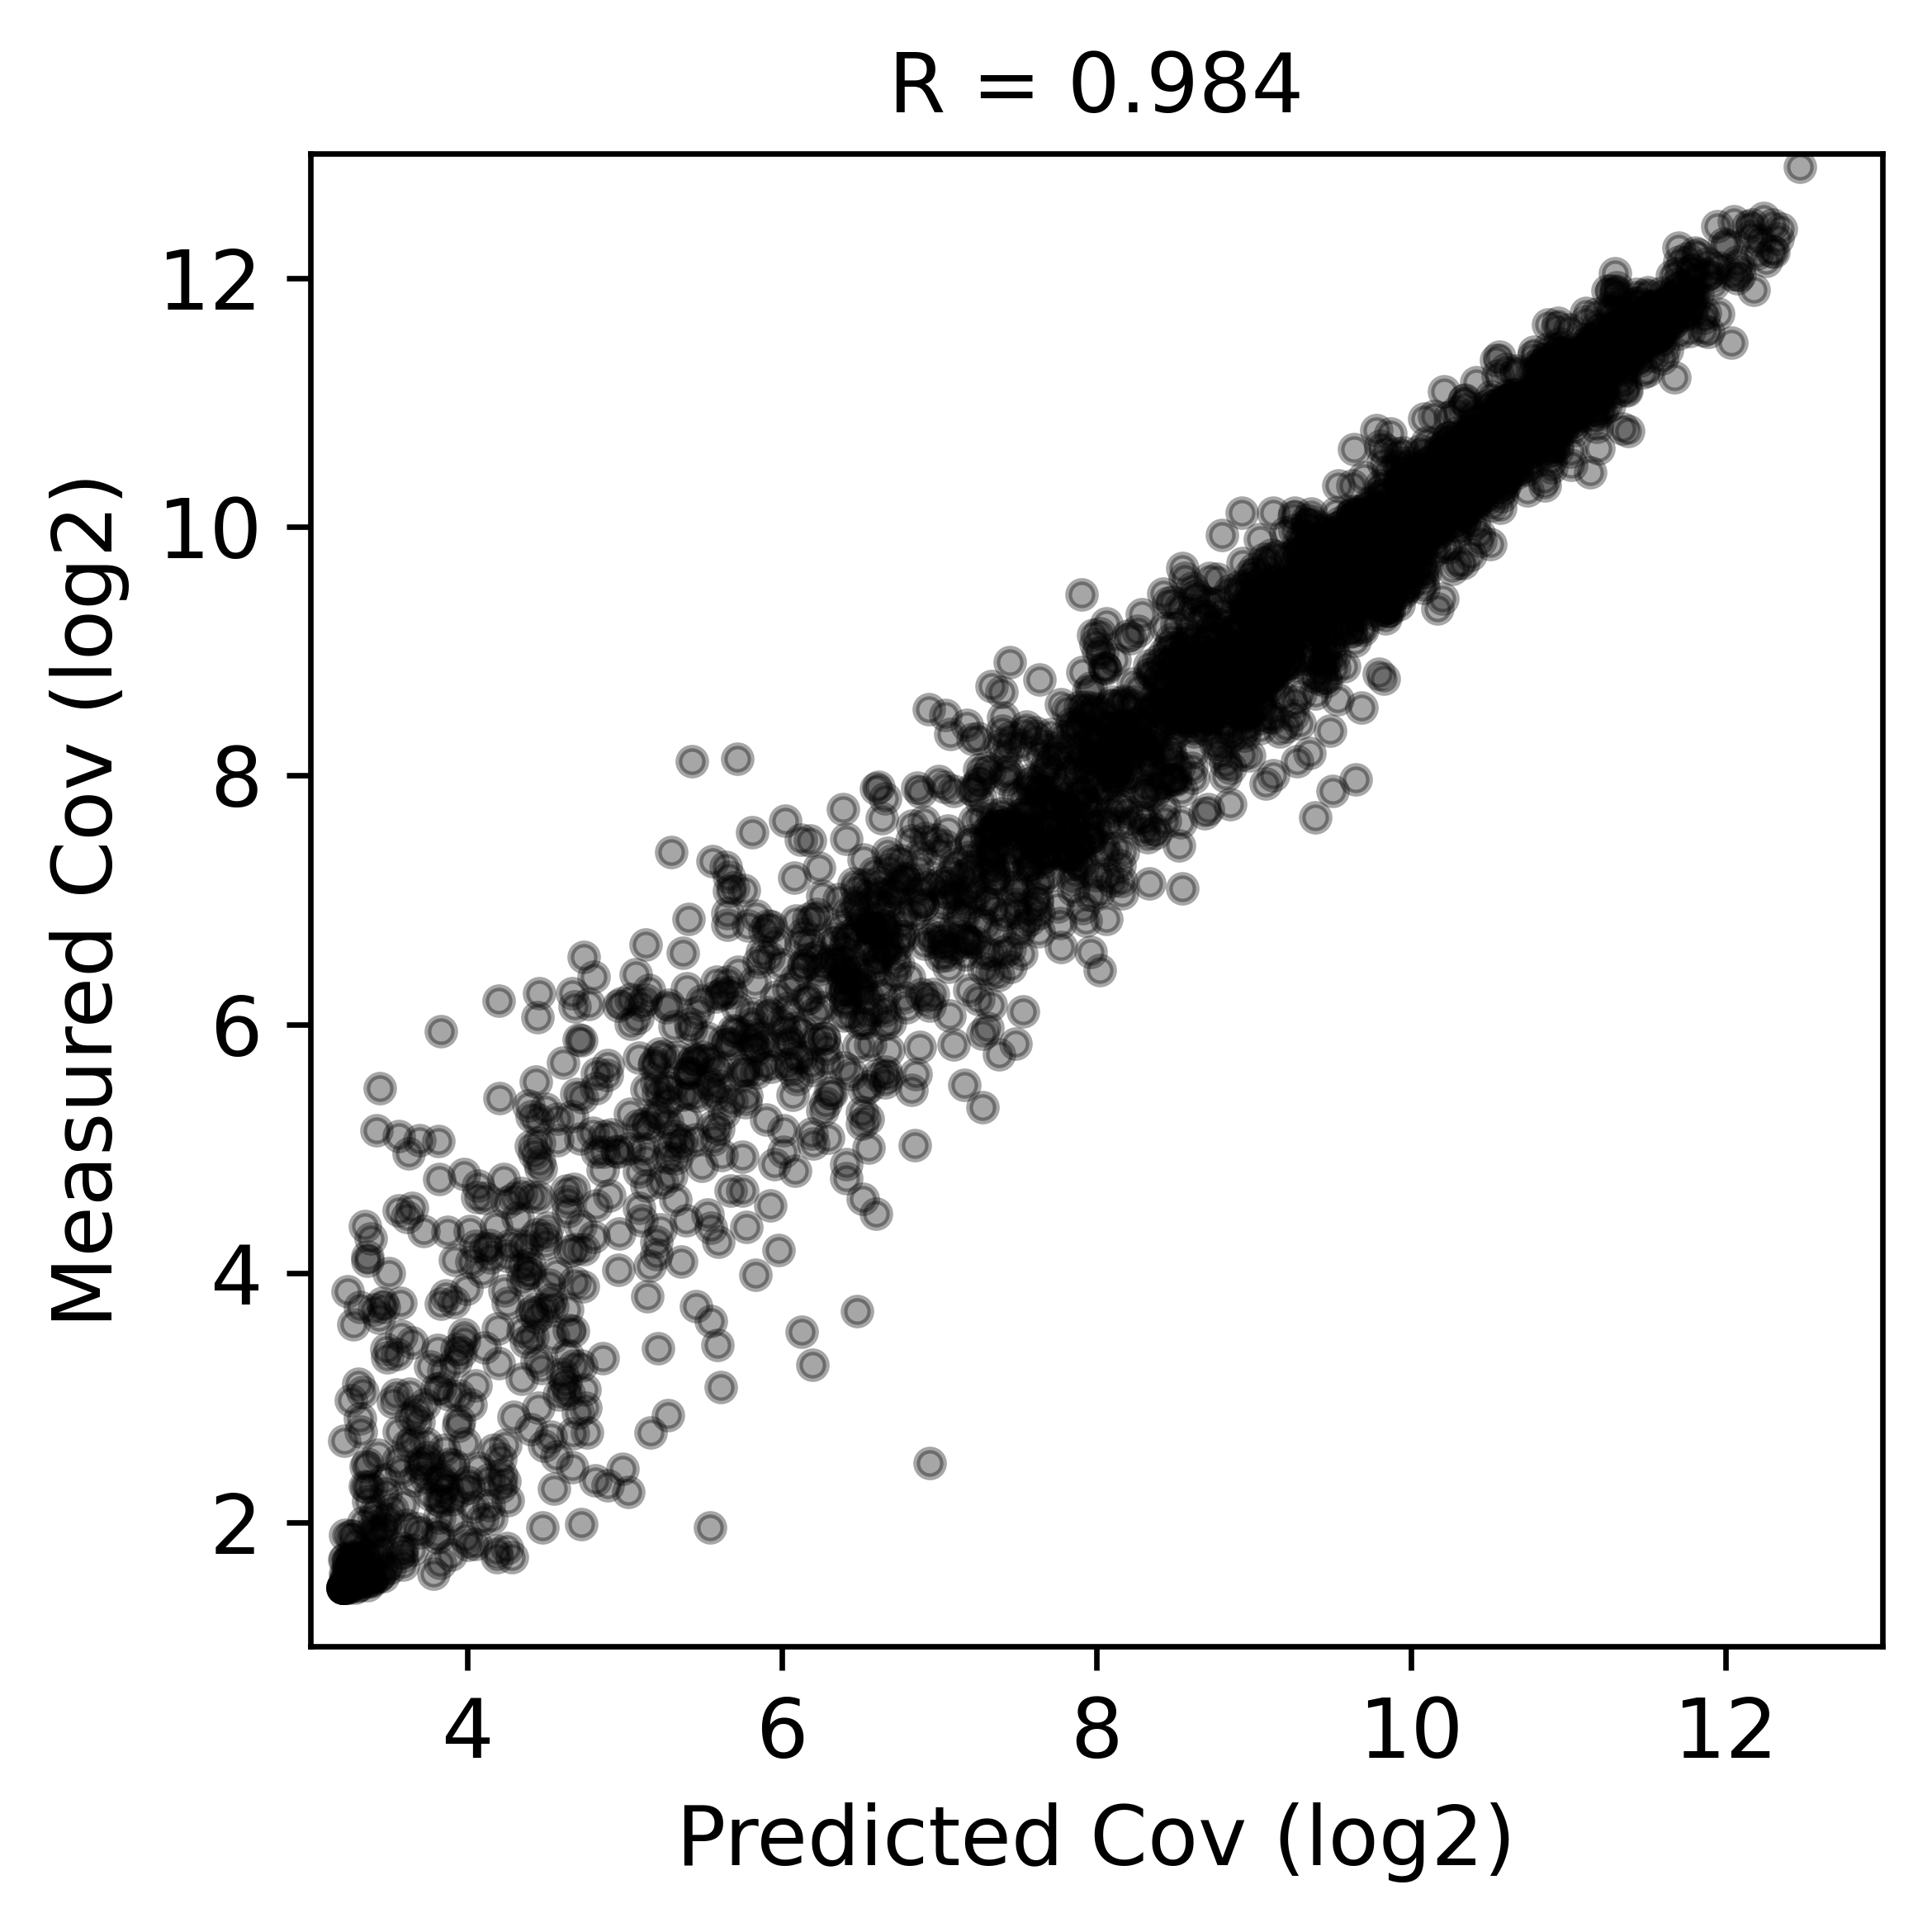

Evaluating for fold = 2
spearman r = 0.978
p = 0.0
n = 2049
(pearson r = 0.968)


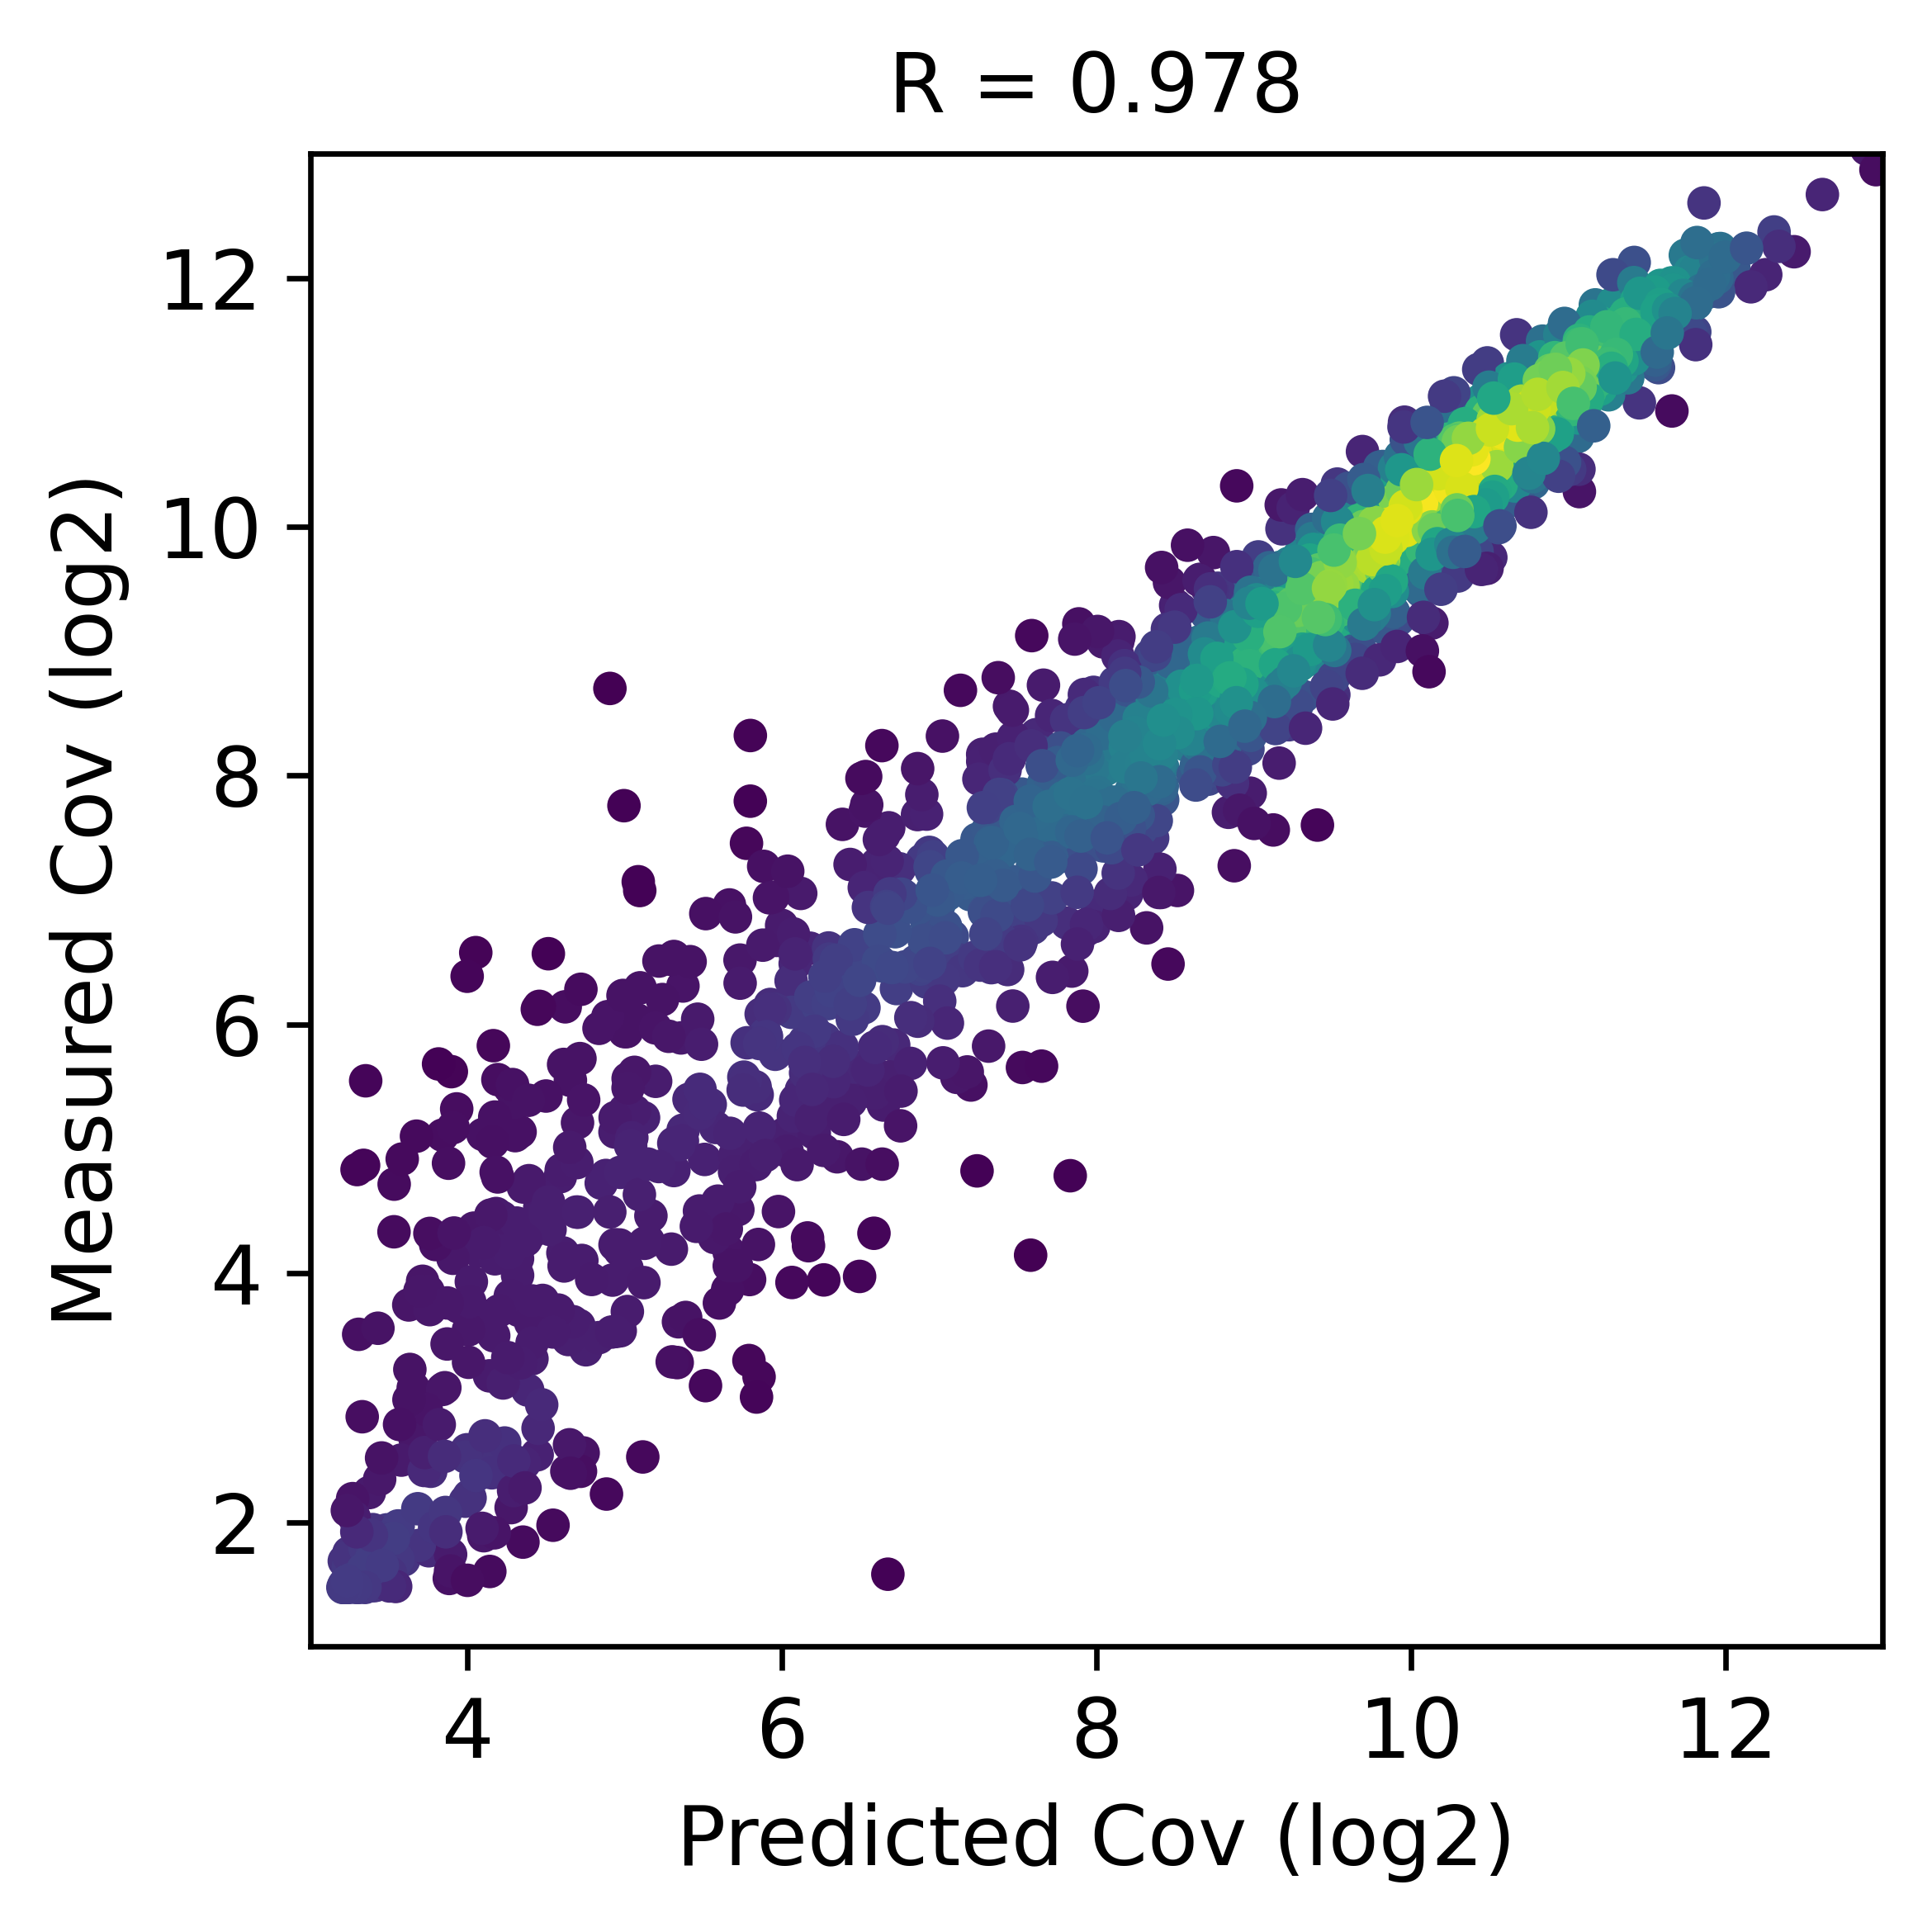

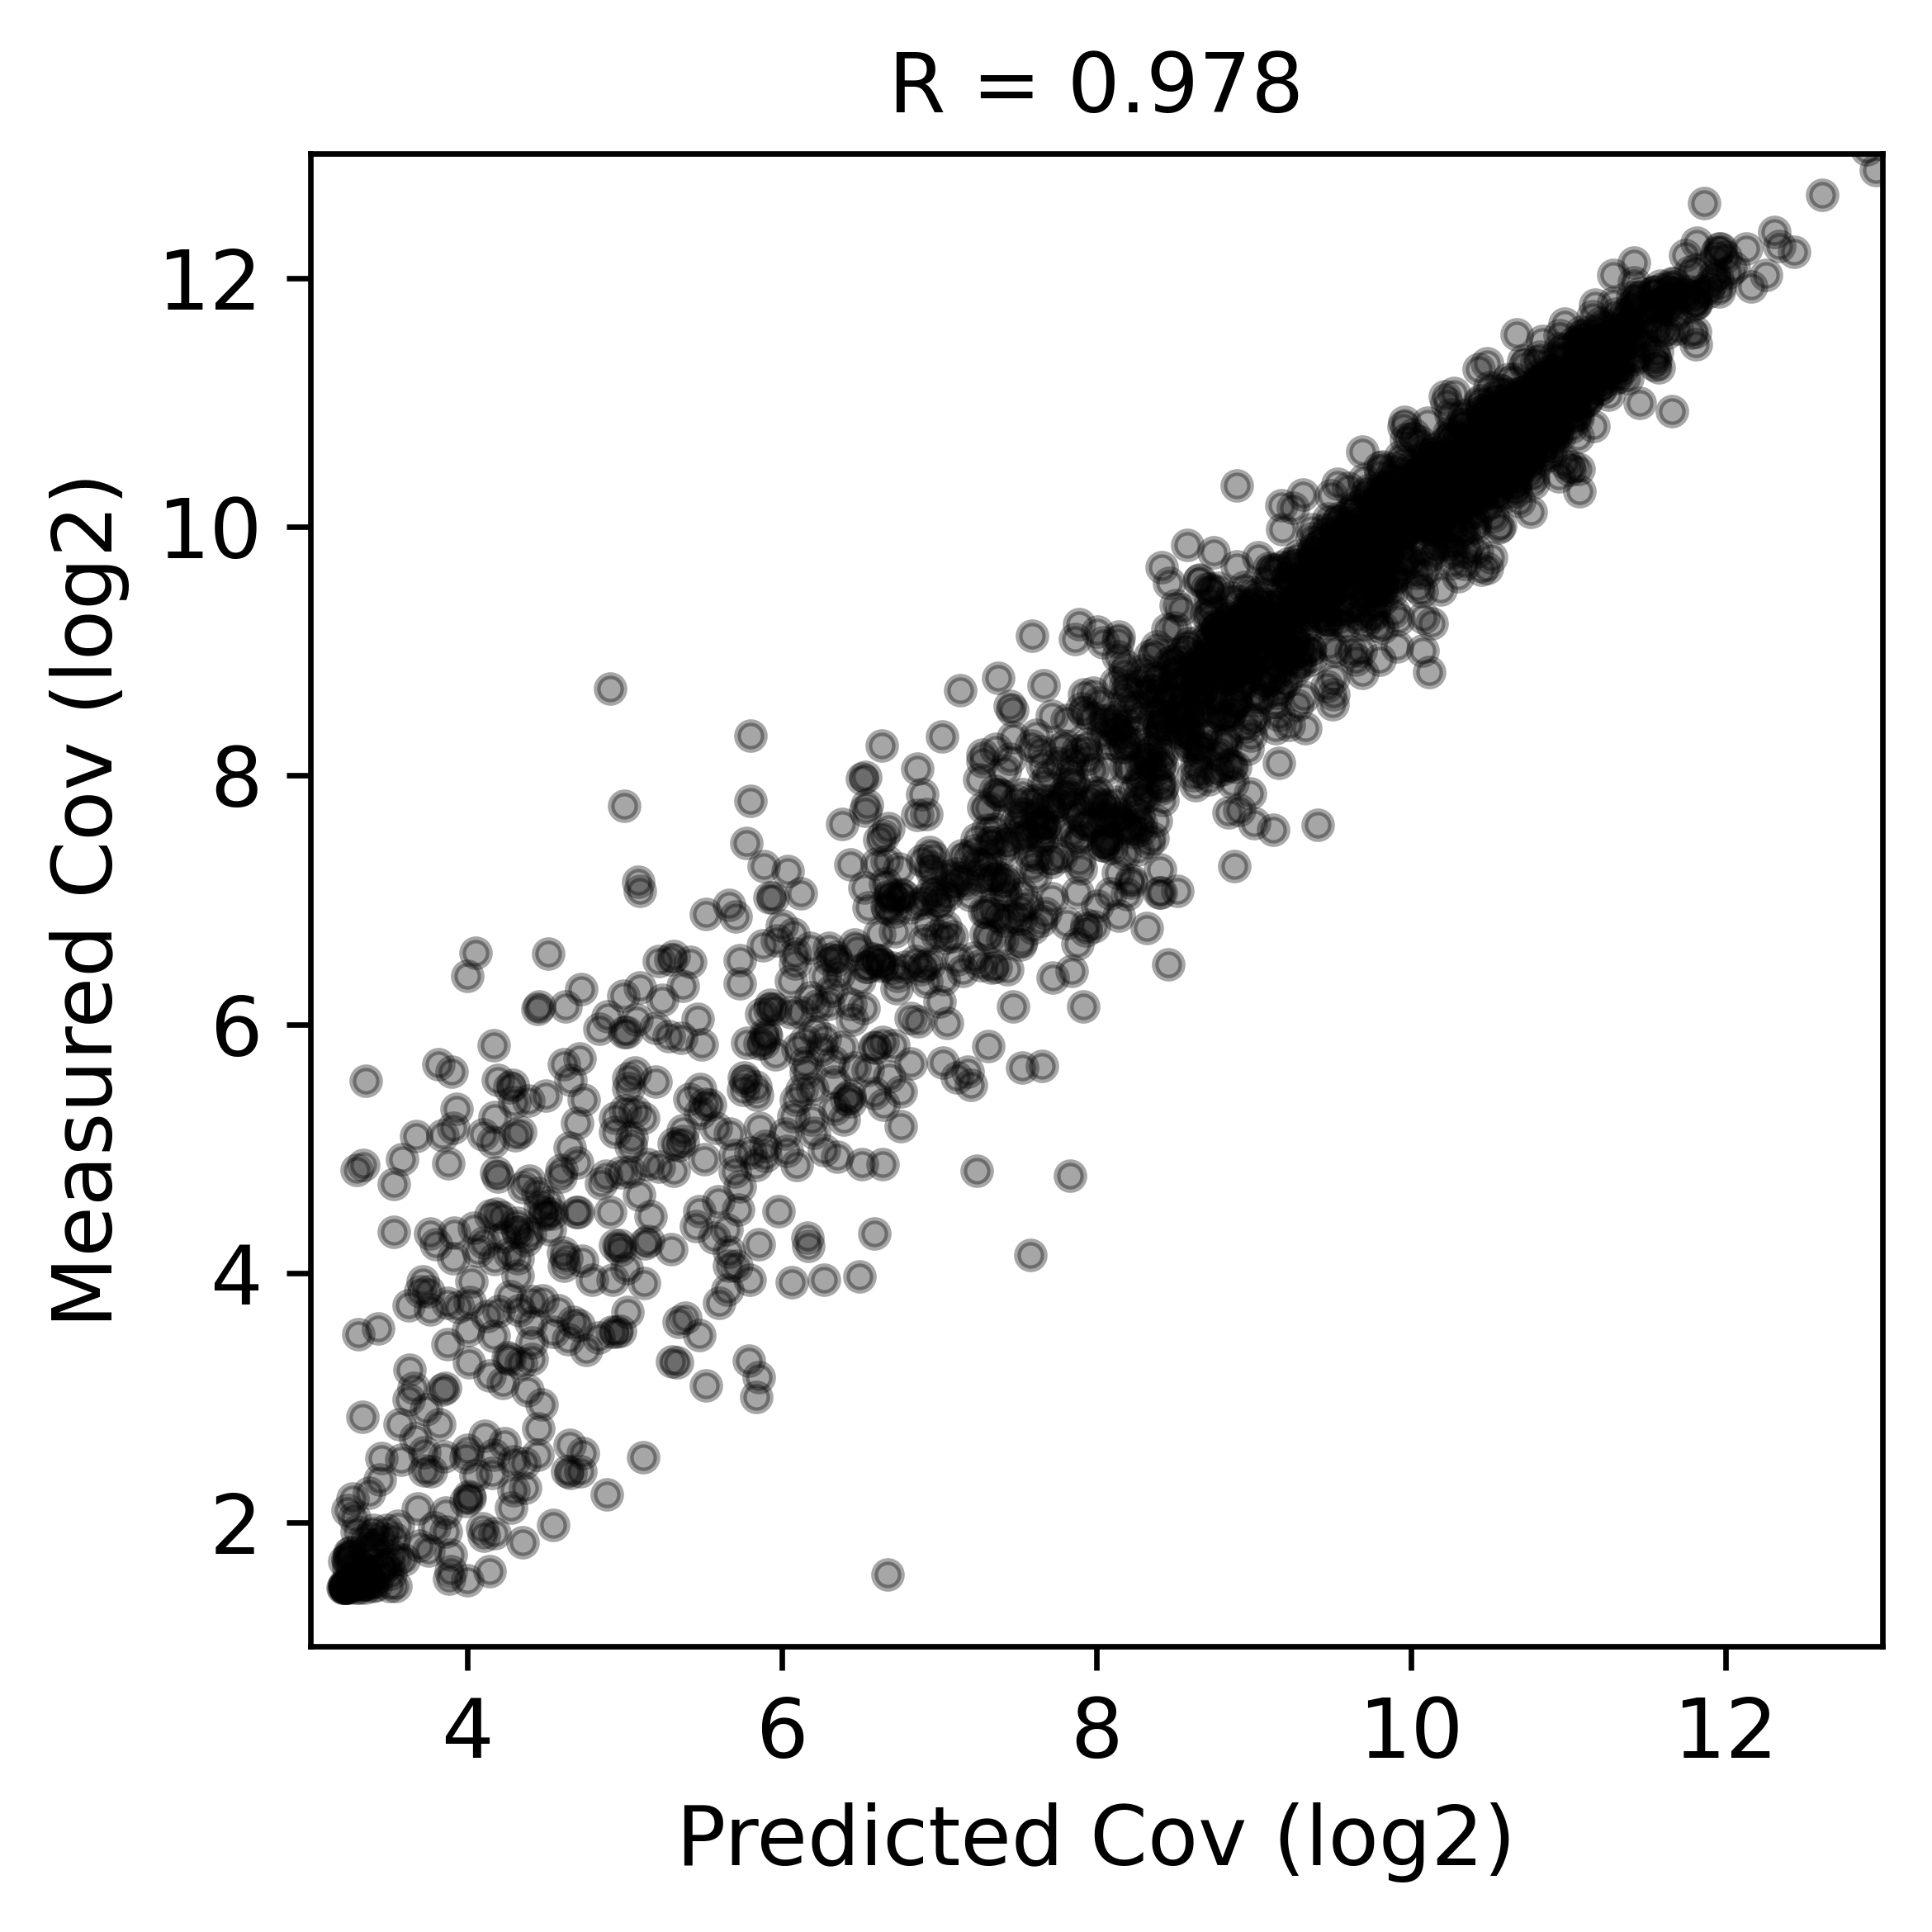

Evaluating for fold = 3
spearman r = 0.898
p = 0.0
n = 1936
(pearson r = 0.913)


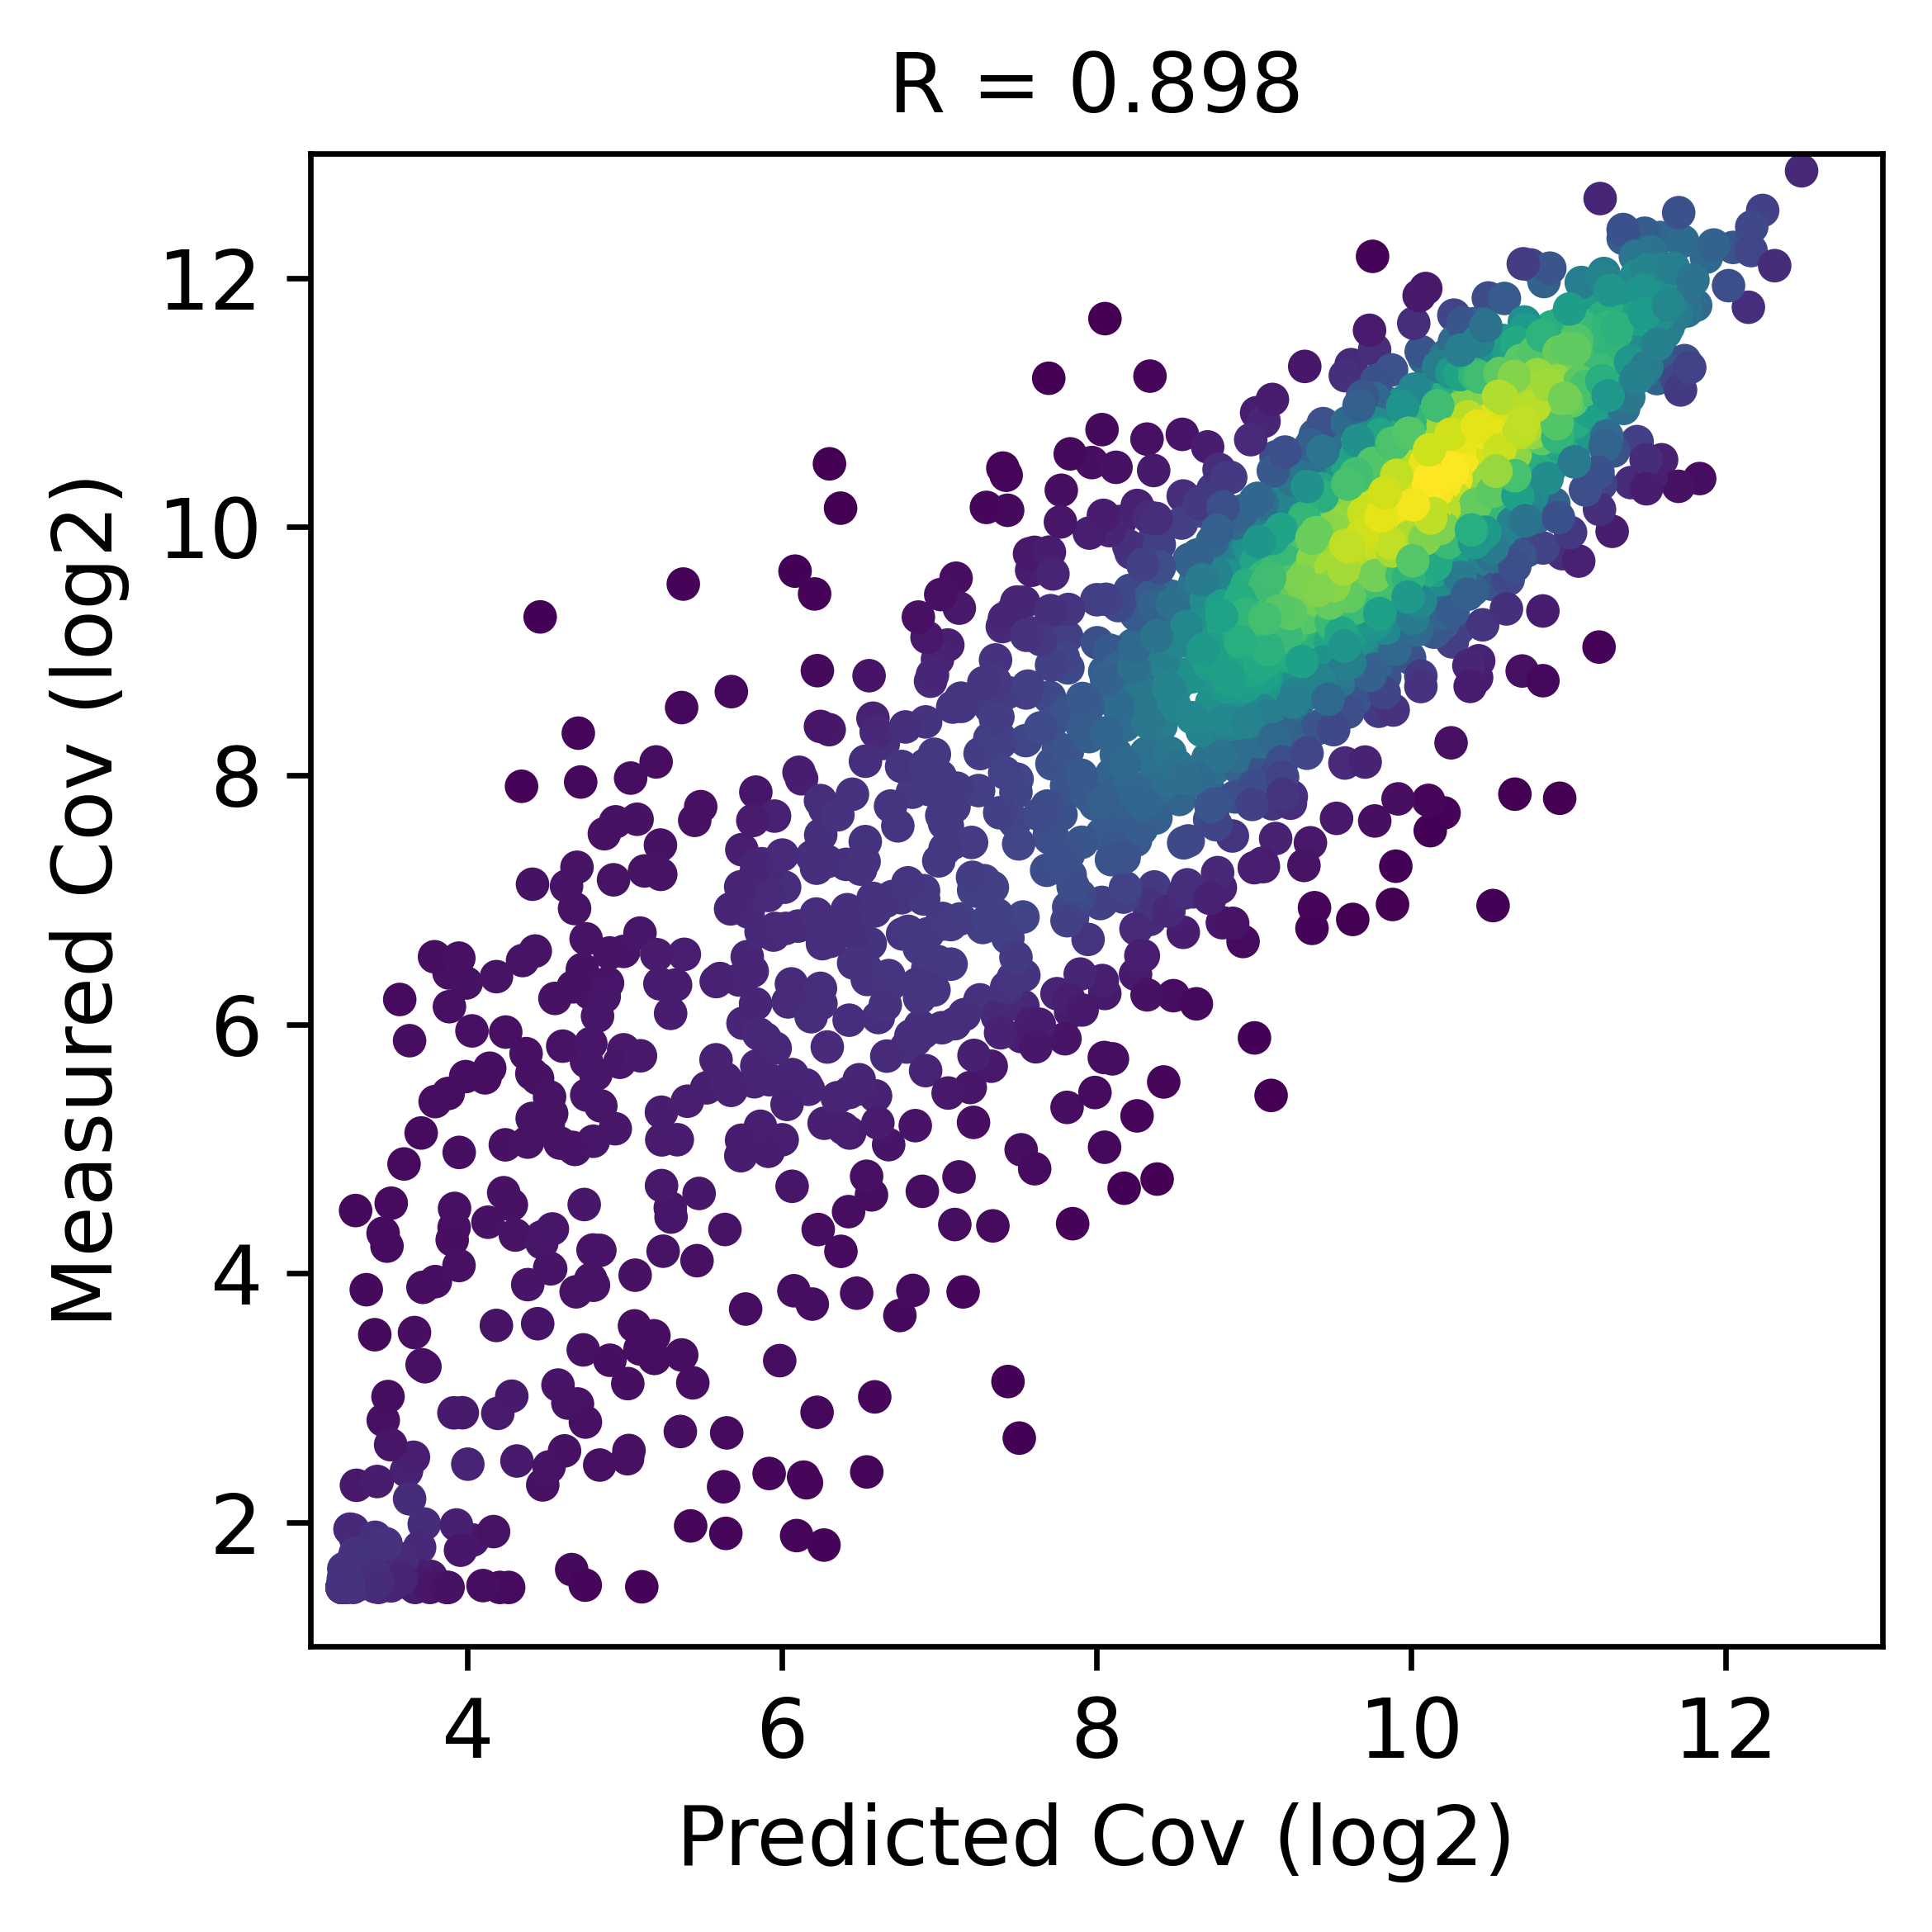

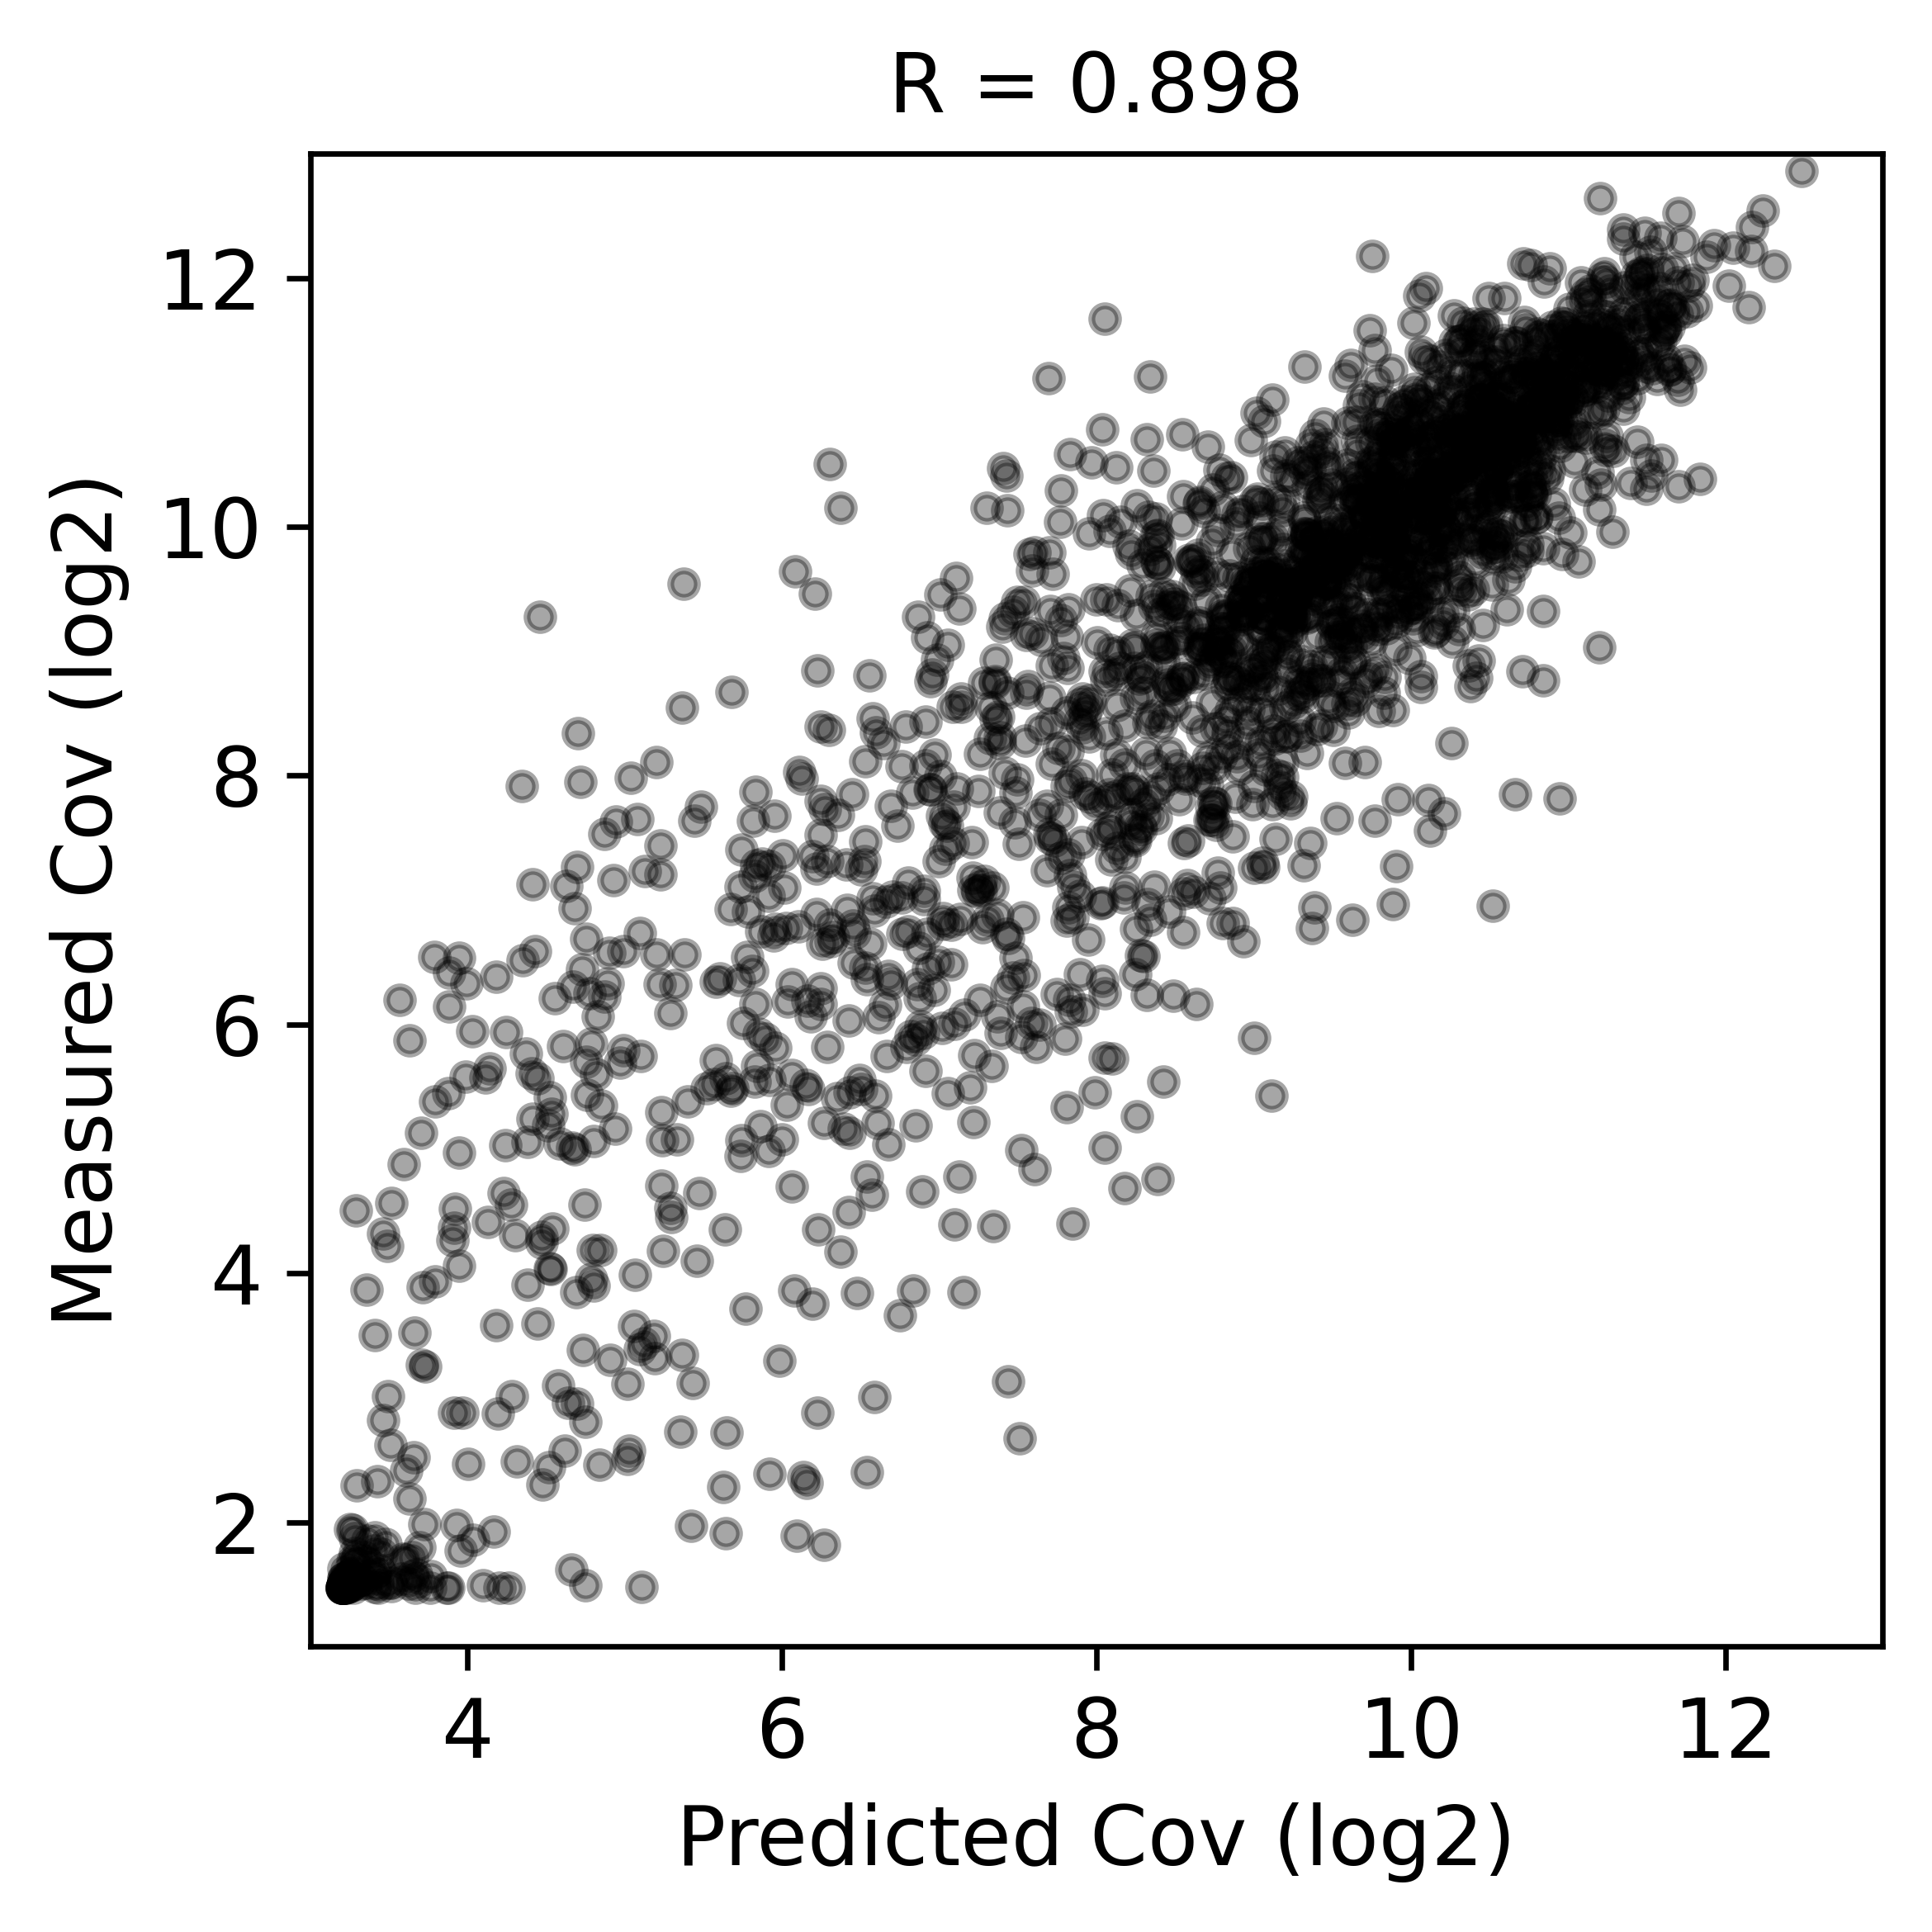

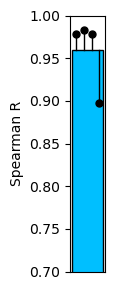

In [14]:
#Evaluate test set performance on held-out genes (tissue-pooled)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_index = [0, 1, 2, 3]

save_figs = True
save_suffix = '_gene_expr_gtex'

n_kde_sample = 500

rs_mat = np.zeros((1, 4), dtype='float32')

#Loop over folds
for fold_ix in fold_index :
    
    print("Evaluating for fold = " + str(fold_ix))

    test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

    #Pool predictions / measurements across tissues or cell types
    test_df['cov_pred'] = 0.
    test_df['cov_true'] = 0.
    n_tissues = 0.
    for tissue in tissues :
        if '_other' not in tissue :
            test_df['cov_pred'] += test_df[tissue + '_test_pred']
            test_df['cov_true'] += test_df[tissue + '_test_true']
            n_tissues += 1.
    
    test_df['cov_pred'] /= n_tissues
    test_df['cov_true'] /= n_tissues
    
    test_df = test_df.loc[~(np.isnan(test_df['cov_pred']) | np.isinf(test_df['cov_pred']))].copy().reset_index(drop=True)
    test_df = test_df.loc[~(np.isnan(test_df['cov_true']) | np.isinf(test_df['cov_true']))].copy().reset_index(drop=True)
    
    #Compare predicted vs. measured gene exon span coverage (derived from RNA-seq tracks)
    
    cov_pred = np.log2(test_df['cov_pred'].values + 1e-6)
    cov_true = np.log2(test_df['cov_true'].values + 1e-6)
    
    sample_index = np.arange(len(test_df), dtype='int32')
    np.random.shuffle(sample_index)
    sample_index = sample_index[:n_kde_sample]

    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)
    
    rs_mat[0, fold_ix] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(test_df)))
    
    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(3, 13)
    plt.ylim(1, 13)

    plt.xlabel("Predicted Cov (log2)", fontsize=12)
    plt.ylabel("Measured Cov (log2)", fontsize=12)
    
    plt.title(label="R = " + str(round(rs_val, 3)))

    plt.tight_layout()
    
    if save_figs and fold_ix == 0 :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.pdf')
        #plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.eps')
    
    plt.show()
    
    #Plot with black color
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred, cov_true, s=15, c='black', alpha=0.35, rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(3, 13)
    plt.ylim(1, 13)

    plt.xlabel("Predicted Cov (log2)", fontsize=12)
    plt.ylabel("Measured Cov (log2)", fontsize=12)
    
    plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

    plt.tight_layout()
    
    if save_figs and fold_ix == 0 :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.pdf')
        #plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.eps')
    
    plt.show()

#Plot performance summary (4-fold CV); with individual fold performance as dots
f = plt.figure(figsize=(1.25, 3)) #, dpi=300

model_colors = [
    'deepskyblue',
]

model_names = [
    None,
]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    for j in range(rs_mat.shape[1]) :
        plt.plot([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5,
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.7, 1)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.eps')

plt.show()
